In [1]:
import pandas as pd
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint as rn
import random
import numpy as np
from sklearn.metrics import r2_score

### Підготовча частина

Завантаження підготовленої таблиці даних

In [2]:
df = pd.read_pickle('data.pickle')
y_true = df.Value.copy()
df.reset_index(inplace=True, drop=True)
df_res = df.copy()

In [3]:
df

,Time,Value
0,1.0,8.0
1,2.0,8.0
2,3.0,9.0
3,10.0,17.0
4,13.0,21.0
...,...,...
95,679.0,60.0
96,683.0,56.0
97,692.0,49.0
98,709.0,39.0


Відображення даних графічно з використанням Seaborn

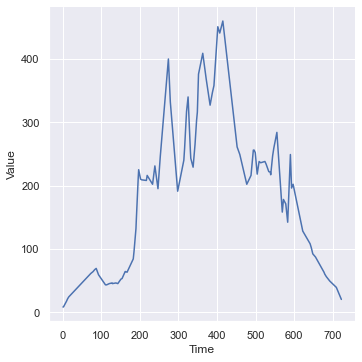

In [4]:
sns.set_theme(style="darkgrid")
sns.relplot(data=df, x='Time', y='Value', kind='line')

Видалення випадковим чином заданого відсотка значень

In [10]:
def count_nan(df_nan):
    value = list(df_nan.isna().sum().loc[df_nan.isna().sum() > 0].sort_values(ascending=True))
    if len(value) > 0:
        return value[0]
    else:
        return 0

def make_nan(df, share=0.2):
    target = np.ceil(len(df) * 0.2)
    while count_nan(df) < target:
        position = rn(0, len(df) - 1)
        df.at[position, 'Value'] = np.nan
    return df

df_nan = make_nan(df, share=0.2)
nan_index = list(df_nan.loc[df_nan.Value.isna()].index.copy())

Перевірка кількості видалених значень у датасеті

In [6]:
print('Отримана таблиця містить {} NaN'.format(count_nan(df_nan)))

Отримана таблиця містить 20 NaN


### Інтерполяція найближчим сусідом (сусідами)

Значення часового ряду, що розглядається, знаходяться на рівних часових інтервалах одне від одного.
Створюємо класс _NeighbourImputer_, який дозволить вставляти значення методом найближчого сусіда. З оглядом на рівні інтервали, метод вставляє правого сусіда, лівого сусіда або середня арифметичне двох сусідів. Метод вказується при ініціалізації інтервала класу.

In [11]:
class NeighbourImputer:
    
    def __init__(self):
        self.X = None
        self.y = None
        self.res = None
    
    def fit_transform(self, X, y):
        """
        Підставляє значення замість NaN, користуючись принципом найближчого сусіда
        """
        self.X = np.array(X)
        self.y = np.array(y)
        self.res = np.array(y)
        for n in range(len(self.y)):
            if np.isnan(y[n]):
                shift_minus, y_minus = self.neighbour(n, up=False)
                shift_plus, y_plus = self.neighbour(n, up=True)
                if (not np.isnan(y_minus)) & (not np.isnan(y_plus)):
                    if np.abs(self.X[shift_minus] - self.X[n]) < np.abs(self.X[shift_plus] - self.X[n]):
                        self.res[n] = y_minus
                    elif  np.abs(self.X[shift_minus] - self.X[n]) > np.abs(self.X[shift_plus] - self.X[n]):
                        self.res[n] = y_plus
                    else:
                        self.res[n] = random.choice([y_minus, y_plus])
                elif (not np.isnan(y_minus)):
                    self.res[n] = y_minus
                elif (not np.isnan(y_plus)):
                    self.res[n] = y_plus
                else:
                    raise ValueError('Некоретний список значень')
        return self.res
    
    def neighbour(self, k, up=True):
        """
        Шукає сусіда із заданої сторони
        Повертає зсув (кількість значень) та значення сусіда
        Такая реалізація дозволяє коректно обробляти ситуації, де декілька NaN є сусідами
        """
        n = k
        if up:
            while np.isnan(self.y[n]):
                if n + 1 < len(self.y):
                    n += 1
                else:
                    return len(self.y) - 1, np.nan
            return np.abs(n - k), self.y[n]
        else:
            while np.isnan(self.y[n]):
                if n - 1 > - 1:
                    n -= 1
                else:
                    return 0, np.nan
            return np.abs(n - k), self.y[n]                   

Проводимо відновлення значень

In [12]:
ni = NeighbourImputer()
y_pred = ni.fit_transform(df_nan.Time, df_nan.Value)
df['NI_imputed'] = y_pred

In [14]:
print('Коефіцієнт детермінації = {}'.format(r2_score(np.array(y_true)[nan_index], np.array(y_pred)[nan_index])))

Коефіцієнт детермінації = 0.710685001702287


Визначимо залежність коефіцієнту детермінації від частки видалених та відновленних значень

Спочатку використаємо звичну ініціалізацію генератора випадкових чисел системним часом

In [20]:
sharea, r2_a = [], []
for s in range(1, 9):
    share = 0.1 * s
    sharea.append(share)
    r2_mean = []
    for i in range(10):
        random.seed()
        df_nan = make_nan(df, share=share)
        y_pred = ni.fit_transform(df_nan.Time, df_nan.Value)
        nan_index = df_nan.loc[df_nan.Value.isna()].index.copy()
        r2_mean.append(r2_score(np.array(y_true)[nan_index], np.array(y_pred)[nan_index]))
    r2_a.append(np.mean(r2_mean))

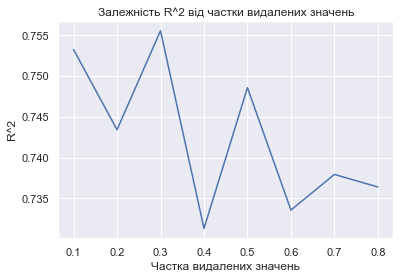

In [21]:
plt.plot(sharea, r2_a)
plt.title('Залежність R^2 від частки видалених значень')
plt.xlabel('Частка видалених значень')
plt.ylabel('R^2')
plt.show()

Тепер використаємо ініціалізацію генератора випадкових чисел одним й тим набором чисел для кожної долі видалення

In [18]:
sharea, r2_a = [], []
seeds = [143, 543, 11, 121, 304, 221, 903, 89, 544, 241]
for s in range(1, 9):
    share = 0.1 * s
    sharea.append(share)
    r2_mean = []
    for i in range(10):
        random.seed(seeds[i])
        df_nan = make_nan(df, share=share)
        y_pred = ni.fit_transform(df_nan.Time, df_nan.Value)
        r2_mean.append(r2_score(np.array(y_true)[nan_index], np.array(y_pred)[nan_index]))
    r2_a.append(np.mean(r2_mean))

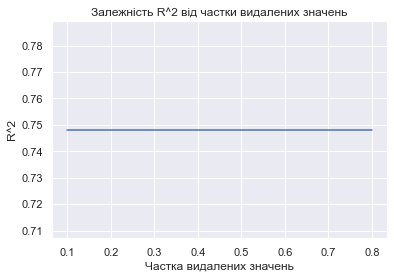

In [19]:
plt.plot(sharea, r2_a)
plt.title('Залежність R^2 від частки видалених значень')
plt.xlabel('Частка видалених значень')
plt.ylabel('R^2')
plt.show()